In [52]:
from PIL import Image,ImageDraw
import json
import numpy as np
import shapely.wkt
import shapely
from collections import defaultdict

In [72]:

import matplotlib.pyplot as plt



def show_colors(binary_mask):
    # Convert the binary_mask to a color image using the damage_intensity_encoding
    damage_colors = {
        0: (0, 0, 0),      # Class 0 - Black (no building)
        1: (255, 255, 255),    # Class 1 - White (no-damage)
        2: (255, 0, 0),    # Class 2 - Red (minor damage)
        3: (0, 255, 0),    # Class 3 - Green (major damage)
        4: (0, 0, 255),    # Class 4 - Blue (destroyed)
        5: (255,255 ,0 ),    # Class 5 - yellow (un-classified)
    }

    # Create an RGB image with the same size as the binary mask
    segmented_image_rgb = Image.new('RGB', binary_mask.size)
    #print(binary_mask.size)

    # Color the pixels of the segmented image based on the damage types
    for x in range(binary_mask.width):
        for y in range(binary_mask.height):
            damage_type = binary_mask.getpixel((x, y))
            color = damage_colors[damage_type]
            segmented_image_rgb.putpixel((x, y), color)

    # Save the segmented image
    segmented_image_rgb.save('./segmented_image_rgb.png')

    # Display the segmented image using matplotlib
    plt.imshow(segmented_image_rgb)
    plt.axis('off')
    plt.show()



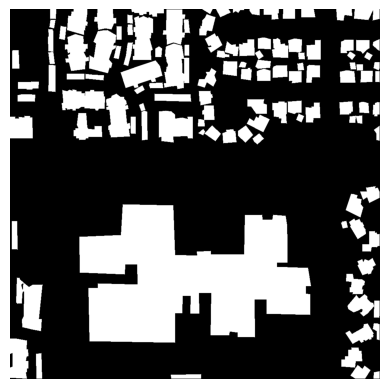

In [73]:


damage_intensity_encoding = defaultdict(lambda: 0)
damage_intensity_encoding['un-classified'] = 5
damage_intensity_encoding['destroyed'] = 4
damage_intensity_encoding['major-damage'] = 3
damage_intensity_encoding['minor-damage'] = 2
damage_intensity_encoding['no-damage'] = 1

img_path='/Users/gmeneses/DScourse/00_capstone/Capstone_Building_Damage/data/last_subset/train/images/hurricane-harvey_00000216_post_disaster.png'

# Load satellite image
satellite_image = Image.open(img_path)
label_path = img_path.replace('png', 'json').replace('images', 'labels')
#print (label_path)

# Load JSON file
label_file = open(label_path)
data=json.load(label_file)

# Create binary mask first

#binary_mask = np.zeros(satellite_image.size, dtype=np.uint8)
mask = Image.new('L', satellite_image.size, 0)
draw = ImageDraw.Draw(mask)


mask_array = np.array(mask)
#print(np.count_nonzero(mask_array.flatten()))
#print(np.bincount(mask_array.flatten()))

for feat in data['features']['xy']:
    
    polygon_geom = shapely.wkt.loads(feat['wkt'])
    polygon_pts = list(polygon_geom.exterior.coords)
    draw.polygon(polygon_pts, outline=1, fill=1)
            
mask_array = np.array(mask)


#print(np.bincount(mask_array.flatten()))
# Create segmented image by assigning damage levels to the building areas

for feat in data['features']['xy']:

    # only images post-disaster will have damage type
    try:
        damage_type = feat['properties']['subtype']
        #print(damage_type)
    except: # pre-disaster damage is default no-damage
        damage_type = "no-damage"
        #print(damage_type)
        continue  

    dam = damage_intensity_encoding[damage_type]
    #print(dam)
    polygon_geom = shapely.wkt.loads(feat['wkt'])
    
    polygon_pts = list(polygon_geom.exterior.coords)
    # Fill the building area with the corresponding damage level
    draw.polygon(polygon_pts, outline=dam, fill=dam)

mask_array = np.array(mask)
#print(np.count_nonzero(mask_array.flatten()))
#print(np.bincount(mask_array.flatten()))
show_colors(mask)
